In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np
from skimage.io import imread

cle.select_device('RTX')

<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

## Loading image data and visualisation

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:252: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


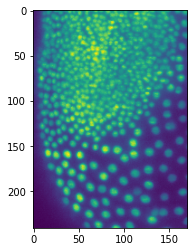

In [2]:
input_image = cle.push_zyx(imread('data/Lund_001000_head_lobe_crop.tif'))

cle.imshow(input_image)

## Spot detection + segmentation

c:\users\rober\miniconda3\lib\site-packages\pyopencl\__init__.py:252: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Number of cells 367.0
center spots:


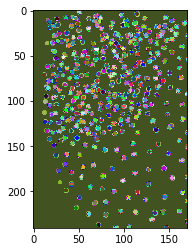

cells:


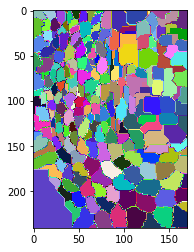

In [3]:
cells, spots = bs.segmentation(input_image)

print("Number of cells", cle.maximum_of_all_pixels(cells))

print("center spots:")
cle.imshow(cle.extend_labels_with_maximum_radius(spots, radius=2), labels=True)
print("cells:")
cle.imshow(cells, labels=True)

## Measurements
### Distances between centroids

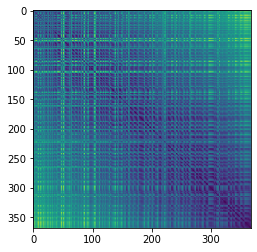

In [4]:
centroids = cle.labelled_spots_to_pointlist(spots)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)
cle.imshow(distance_matrix)

[ 0.         2.236068  12.4499     2.236068  11.224972   6.6332493
  8.485281   7.28011   15.394804  12.4499   ] ...


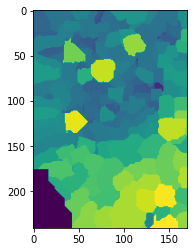

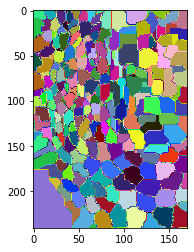

In [5]:
nearest_neighbor_distance = cle.average_distance_of_n_shortest_distances(distance_matrix, n=1)
print(nearest_neighbor_distance[0, 0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, nearest_neighbor_distance)
cle.imshow(parametric_image)
cle.imshow(cells, labels=True)

## Measure number of neighbors

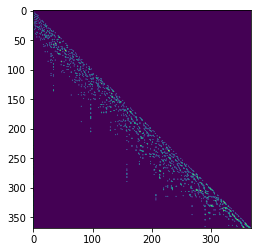

In [6]:
touch_matrix = cle.generate_touch_matrix(cells)
cle.imshow(touch_matrix)

[339.   3.   4.   7.   5.   4.   8.   7.   4.   6.] ...
[0. 3. 4. 7. 5. 4. 8. 7. 4. 6.] ...


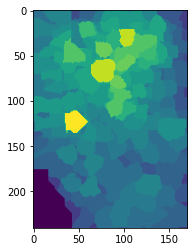

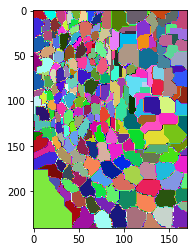

In [7]:
number_of_neighbors = cle.count_touching_neighbors(touch_matrix)
print(number_of_neighbors[0, 0:10], "...")

# set the number of neighbors of background (column 0) to 0 for visualisation purposes
cle.set_column(number_of_neighbors, 0, 0)
print(number_of_neighbors[0, 0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, number_of_neighbors)
cle.imshow(parametric_image)
cle.imshow(cells, labels=True)

## Clustering
We now take our measuremnts and cluster cells into two groups: Hopefully, embryo and serosa.

In [8]:
num_classes = 2

raw_data = [
    cle.pull_zyx(nearest_neighbor_distance)[0],
    cle.pull_zyx(number_of_neighbors)[0],
]

data = np.asarray(raw_data).T
print(data.shape)

(368, 2)


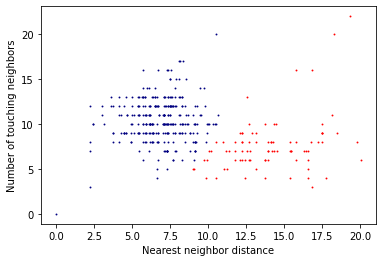

In [9]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
colors = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# K-means clustering
kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(data)

km_prediction = kmeans.predict(data)

for i in range(0, num_classes):
    color = colors[i]
    plt.scatter(data[km_prediction == i, 0], data[km_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

[0. 1. 2. 1. 2. 1. 1. 1. 2. 2.] ...


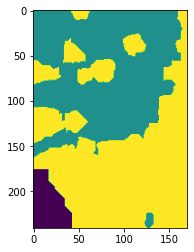

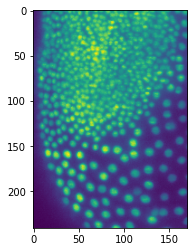

In [11]:
prediction_vector = cle.push_zyx(np.asarray([km_prediction]) + 1)

# set background to 0
cle.set_column(prediction_vector, 0, 0)
print(prediction_vector[0,0:10], "...")

# make a parametric image
parametric_image = cle.replace_intensities(cells, prediction_vector)
cle.imshow(parametric_image)
cle.imshow(input_image)

## Determining the number of classes
We now run the k-means clustering for multiple number of classes and determine the sum of the squared distances of the data points agains their cluster centers.

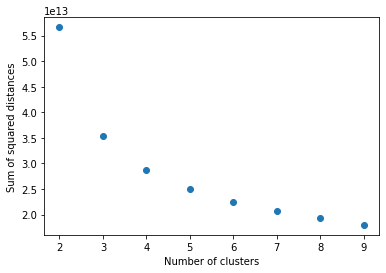

In [14]:
elbow_data = np.asarray([[num_classes, KMeans(n_clusters=num_classes, random_state=0).fit(data).inertia_] for num_classes in range(2, 10)]).T

plt.scatter(elbow_data[0], elbow_data[1])
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.show()

Let's repeat that on more data points. We use multiple datasets (timepoints) of the developing embryo.

Analysing time point just after 0.0 s
------------------------
imread_raw took 0.12208843231201172
(213, 710, 355)
(1406, 1406)


c:\structure\code\beetlesafari\beetlesafari\analysis\_collect_statistics.py:64: RuntimeWarning: invalid value encountered in true_divide
  dict['aspect_ratio_between_touching_neighbors'] = _regionprops_to_1d_np(dict['maximum_distance_of_touching_neighbors'] / dict['minimum_distance_of_touching_neighbors'])


data shape (1406, 170)
Analysing time point just after 4114.285714285715 s
------------------------
imread_raw took 0.17220449447631836
(213, 710, 355)
(1256, 1256)
data shape (2662, 170)
Analysing time point just after 8228.57142857143 s
------------------------
imread_raw took 0.16032719612121582
(213, 710, 355)
(1199, 1199)
data shape (3861, 170)
Analysing time point just after 12342.857142857145 s
------------------------
imread_raw took 0.18214154243469238
(213, 710, 355)
(650, 650)
data shape (4511, 170)
Analysing time point just after 16457.14285714286 s
------------------------
imread_raw took 0.19087624549865723
(213, 710, 355)
(1194, 1194)
data shape (5705, 170)
Analysing time point just after 20571.428571428572 s
------------------------
imread_raw took 0.17496371269226074
(213, 710, 355)
(1088, 1088)
data shape (6793, 170)
Analysing time point just after 24685.71428571429 s
------------------------
imread_raw took 0.19072818756103516
(213, 710, 355)
(1413, 1413)
data shape 

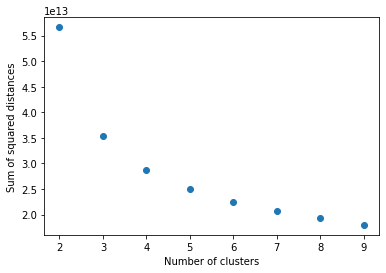

In [13]:
cc_dataset = bs.ClearControlDataset('C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR/')

start_time_in_seconds = bs.hours_to_seconds(0)
end_time_in_seconds = bs.hours_to_seconds(24)
n_timepoints = 20

bundle = bs.from_dataset_to_raw_statistics(cc_dataset, start_time_in_seconds, end_time_in_seconds, num_timepoints=n_timepoints)
data = bundle['data']

elbow_data = np.asarray([[num_classes, KMeans(n_clusters=num_classes, random_state=0).fit(data).inertia_] for num_classes in range(2, 10)]).T

plt.scatter(elbow_data[0], elbow_data[1])
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.show()